In [1]:
import json
import os
import re
import subprocess
import time
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Configuration ---
# Path to the main script to be executed
MAIN_SCRIPT_PATH = "main.py"
# Directory where logs are stored, as defined in main.py
LOGS_DIR = "logs"
# Number of times to run the test
NUM_TRIALS = 3




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\rockhopper\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\rockhopper\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\rockhopper\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\rockhopper\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\rockhopper\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\rockhopper\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start

AttributeError: _ARRAY_API not found

In [2]:
# --- Helper Functions for Execution and Log Parsing ---

def run_main_script():
    """
    Executes the main.py script as a separate process and waits for it to complete.
    Returns the path to the directory for this specific run.
    """
    print(f"--- Starting new trial ---")
    # Using subprocess to run the script in an isolated environment
    # This is more robust than importing and calling main()
    process = subprocess.Popen(["python", MAIN_SCRIPT_PATH], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    # We can monitor stdout in real-time if needed
    while True:
        output = process.stdout.readline()
        if output == '' and process.poll() is not None:
            break
        if output:
            print(output.strip())

    stderr = process.communicate()[1]
    if process.returncode != 0:
        print("\n--- SCRIPT FAILED ---")
        print(stderr)
        return None, "FAILED"
    
    print("--- Script execution finished ---")
    
    # Find the latest run directory created by the script
    run_dirs = sorted([os.path.join(LOGS_DIR, d) for d in os.listdir(LOGS_DIR) if os.path.isdir(os.path.join(LOGS_DIR, d))])
    latest_run_dir = run_dirs[-1] if run_dirs else None
    
    return latest_run_dir, "COMPLETED"


def parse_log_file(log_path):
    """
    Parses a single task log file to extract key metrics.
    """
    with open(log_path, 'r', encoding='utf-8') as f:
        log_content = f.read()

    # Metrics to extract
    start_time_str = re.search(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - INFO - browser_use.Agent", log_content)
    end_time_str = re.findall(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})", log_content)
    
    # 1. Speed (Duration)
    duration_seconds = 0
    if start_time_str and end_time_str:
        start_time = datetime.strptime(start_time_str.group(1), '%Y-%m-%d %H:%M:%S,%f')
        end_time = datetime.strptime(end_time_str[-1], '%Y-%m-%d %H:%M:%S,%f')
        duration_seconds = (end_time - start_time).total_seconds()
        
    # 2. Cost (Tokens)
    total_tokens = 0
    token_matches = re.findall(r"\[cost\].*?(\d+\.\d+k|\d+k|\d+) tokens", log_content)
    # A more robust regex for the summary line
    summary_match = re.search(r"gemini-2.0-flash: (\d+\.?\d*k) tokens", log_content)
    if summary_match:
        token_str = summary_match.group(1).replace('k', '')
        total_tokens = float(token_str) * 1000
    
    # 3. Robustness (Number of recovery steps)
    # A "recovery step" is when the agent has to re-plan due to page changes.
    recovery_steps = len(re.findall(r"Element index changed after action|Something new appeared after action", log_content))
    
    # 4. Total Steps / Actions
    total_steps = len(re.findall(r"📍 Step \d+:", log_content))
    total_actions = len(re.findall(r"☑️ Executed action", log_content))

    # 5. Goal Completion
    task_completed = "✅ Task completed successfully" in log_content
    
    return {
        "completed": task_completed,
        "duration_seconds": duration_seconds,
        "total_tokens": total_tokens,
        "recovery_steps": recovery_steps,
        "total_steps": total_steps,
        "total_actions": total_actions
    }


def analyze_run(run_dir):
    """
    Analyzes all task logs within a single run directory.
    """
    if not run_dir or not os.path.exists(run_dir):
        return []
        
    results = []
    task_dirs = sorted([d for d in os.listdir(run_dir) if d.startswith("task")])
    
    for task_dir in task_dirs:
        # Assuming the log file is named 'conversation.jsonl' or similar, find the main log
        log_file = os.path.join(run_dir, task_dir, "full_conversation.log")
        if not os.path.exists(log_file):
            print(f"Warning: Log file not found at {log_file}")
            continue
            
        task_metrics = parse_log_file(log_file)
        task_metrics["task_name"] = task_dir
        results.append(task_metrics)
        
    return results



===== EXECUTING TRIAL 1/3 =====
--- Starting new trial ---

--- SCRIPT FAILED ---
Traceback (most recent call last):
  File "c:\bkds\capstone\aitinerary-capstone\main.py", line 5, in <module>
    from langchain_anthropic import ChatAnthropic
ModuleNotFoundError: No module named 'langchain_anthropic'

Trial 1 failed to complete.

===== EXECUTING TRIAL 2/3 =====
--- Starting new trial ---

--- SCRIPT FAILED ---
Traceback (most recent call last):
  File "c:\bkds\capstone\aitinerary-capstone\main.py", line 5, in <module>
    from langchain_anthropic import ChatAnthropic
ModuleNotFoundError: No module named 'langchain_anthropic'

Trial 2 failed to complete.

===== EXECUTING TRIAL 3/3 =====
--- Starting new trial ---

--- SCRIPT FAILED ---
Traceback (most recent call last):
  File "c:\bkds\capstone\aitinerary-capstone\main.py", line 5, in <module>
    from langchain_anthropic import ChatAnthropic
ModuleNotFoundError: No module named 'langchain_anthropic'

Trial 3 failed to complete.


=====

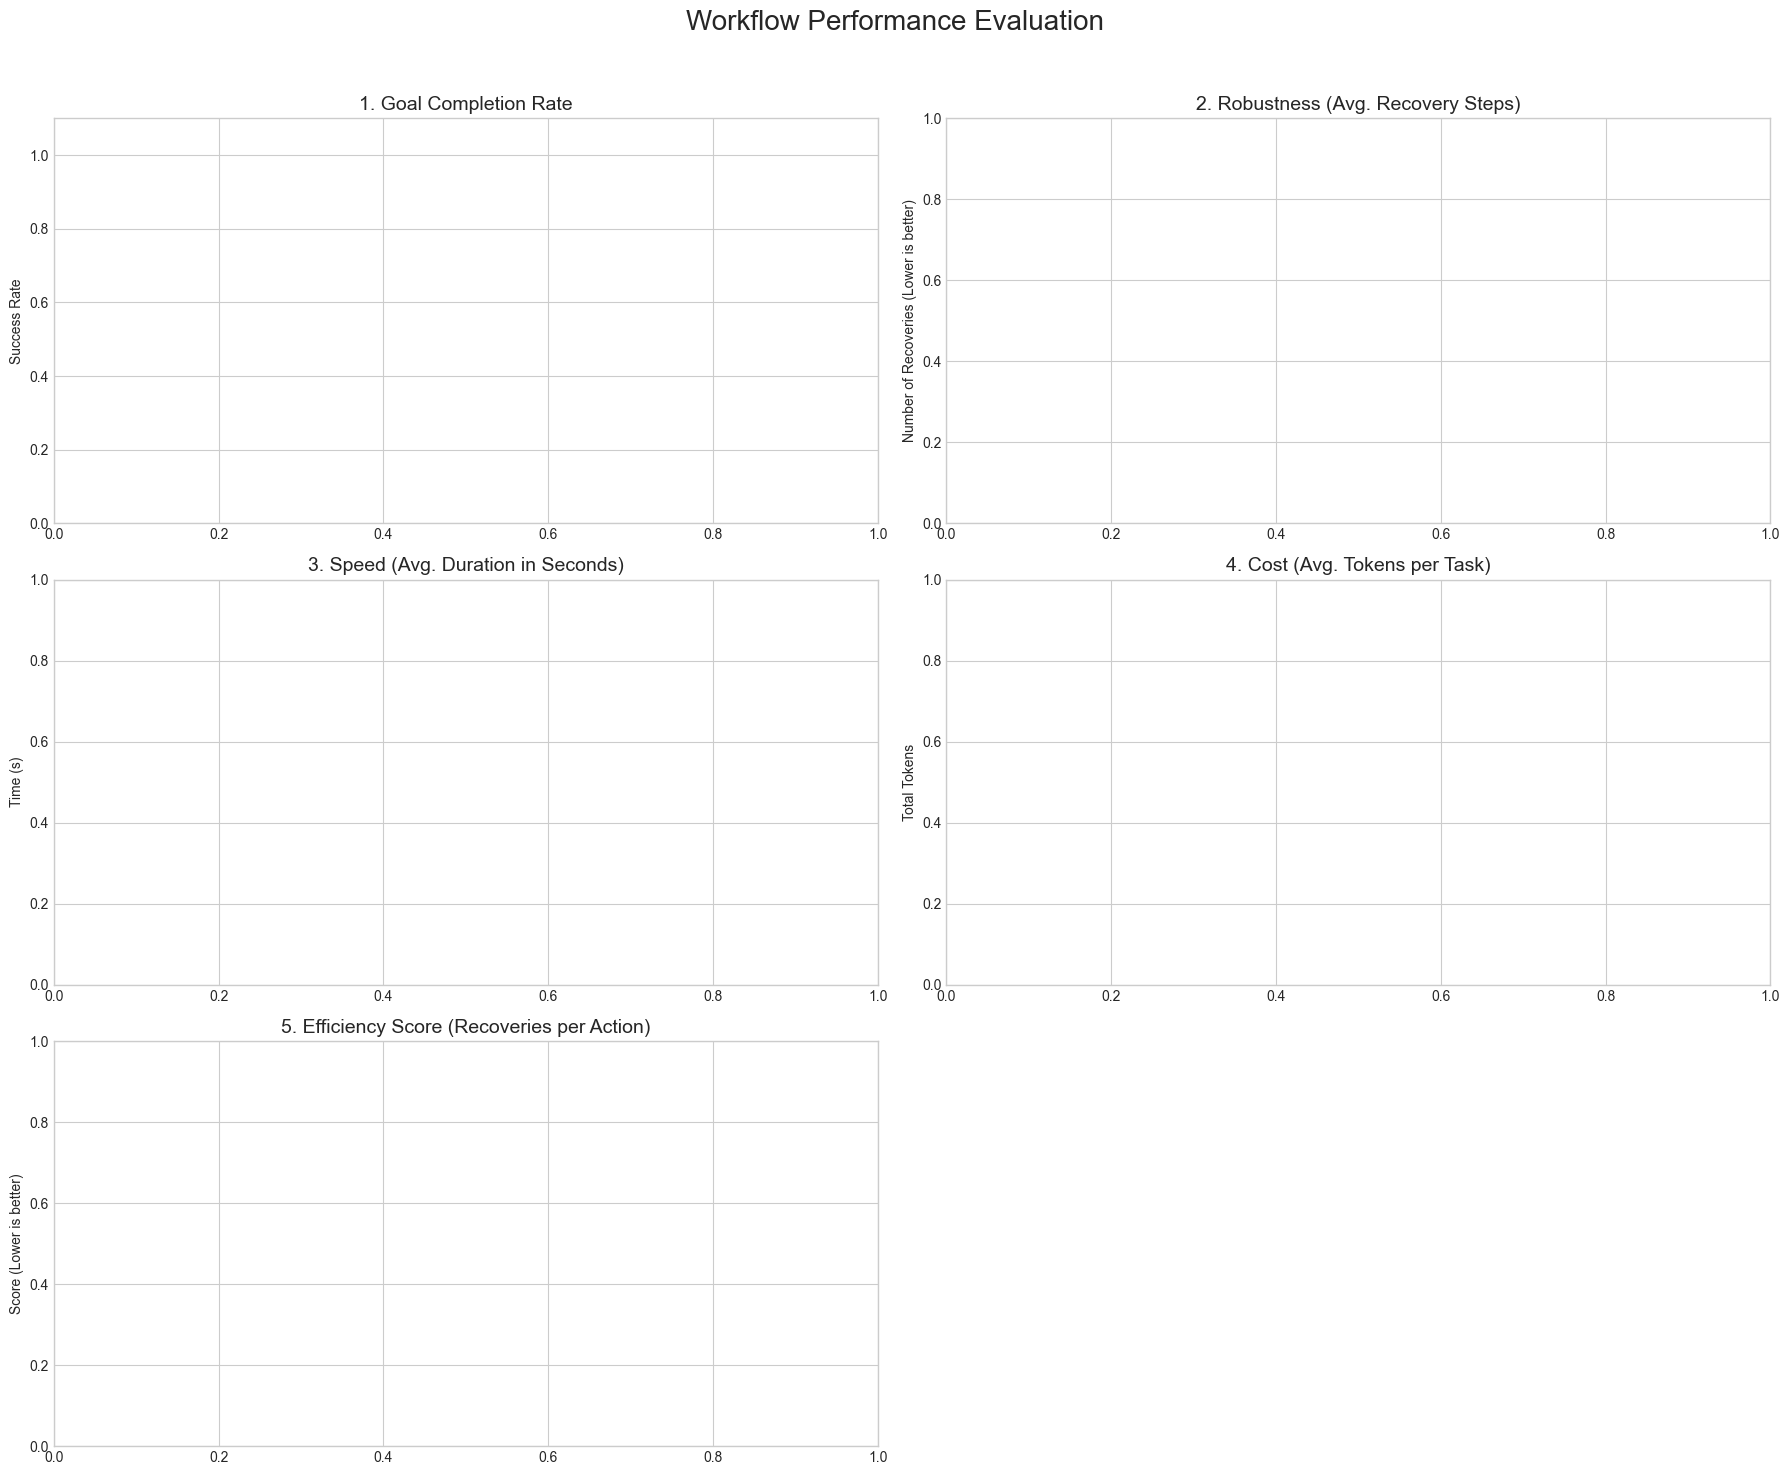

In [3]:

# --- Main Execution Loop ---

all_trials_data = []

for i in range(NUM_TRIALS):
    print(f"\n===== EXECUTING TRIAL {i+1}/{NUM_TRIALS} =====")
    
    # Clean up old logs before starting a new set of trials if desired
    # if i == 0 and os.path.exists(LOGS_DIR):
    #     shutil.rmtree(LOGS_DIR)

    run_dir, status = run_main_script()
    
    if status == "COMPLETED" and run_dir:
        trial_results = analyze_run(run_dir)
        for result in trial_results:
            result["trial"] = i + 1
            all_trials_data.append(result)
    else:
        # Log a failed trial
        print(f"Trial {i+1} failed to complete.")
        all_trials_data.append({
            "trial": i+1, "task_name": "run_failed", "completed": False, 
            "duration_seconds": -1, "total_tokens": -1, "recovery_steps": -1, 
            "total_steps": -1, "total_actions": -1
        })

# --- Data Analysis and Visualization ---

print("\n\n===== ANALYSIS OF RESULTS =====")

if not all_trials_data:
    print("No data collected. Exiting analysis.")
else:
    df = pd.DataFrame(all_trials_data)
    
    # --- Metric Calculation ---
    
    # 1. Goal Completion Rate
    # The percentage of tasks that successfully completed.
    completion_rate = df.groupby('task_name')['completed'].mean().reset_index()
    completion_rate = completion_rate.rename(columns={'completed': 'completion_rate'})

    # Aggregate other metrics by taking the mean of successful runs
    successful_runs = df[df['completed'] == True]
    aggregated_metrics = successful_runs.groupby('task_name').agg({
        'duration_seconds': 'mean',
        'total_tokens': 'mean',
        'recovery_steps': 'mean',
        'total_steps': 'mean',
        'total_actions': 'mean'
    }).reset_index()

    # 5. Efficiency Score (New Metric)
    # A measure of how many recovery steps were needed per action. Lower is better.
    # A score of 0 means no recoveries were needed.
    aggregated_metrics['efficiency_score'] = aggregated_metrics['recovery_steps'] / aggregated_metrics['total_actions']

    # Merge completion rate with other metrics
    final_summary = pd.merge(aggregated_metrics, completion_rate, on='task_name')

    print("\n--- Overall Performance Summary (Averaged over successful trials) ---")
    print(final_summary.to_string())

    # --- Visualization ---
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.suptitle('Workflow Performance Evaluation', fontsize=20)
    axes = axes.flatten()

    # 1. Goal Completion Rate
    sns.barplot(data=final_summary, x='task_name', y='completion_rate', ax=axes[0], palette='Greens_d')
    axes[0].set_title('1. Goal Completion Rate', fontsize=14)
    axes[0].set_ylabel('Success Rate')
    axes[0].set_ylim(0, 1.1)

    # 2. Robustness (Recovery Steps)
    sns.barplot(data=final_summary, x='task_name', y='recovery_steps', ax=axes[1], palette='Reds_d')
    axes[1].set_title('2. Robustness (Avg. Recovery Steps)', fontsize=14)
    axes[1].set_ylabel('Number of Recoveries (Lower is better)')

    # 3. Speed (Avg. Duration)
    sns.barplot(data=final_summary, x='task_name', y='duration_seconds', ax=axes[2], palette='Blues_d')
    axes[2].set_title('3. Speed (Avg. Duration in Seconds)', fontsize=14)
    axes[2].set_ylabel('Time (s)')

    # 4. Cost (Avg. Tokens)
    sns.barplot(data=final_summary, x='task_name', y='total_tokens', ax=axes[3], palette='Purples_d')
    axes[3].set_title('4. Cost (Avg. Tokens per Task)', fontsize=14)
    axes[3].set_ylabel('Total Tokens')

    # 5. Efficiency Score
    sns.barplot(data=final_summary, x='task_name', y='efficiency_score', ax=axes[4], palette='Oranges_d')
    axes[4].set_title('5. Efficiency Score (Recoveries per Action)', fontsize=14)
    axes[4].set_ylabel('Score (Lower is better)')
    
    # Hide the last subplot if it's not used
    axes[5].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()